 **Hello everyone, in this notebook, I will be utilizing transfer learning to build our model. I've fine-tuned a model based on data, and throughout the model-building process, I will provide detailed explanations of my thought process and how to make adjustments to the model. If you find this approach helpful in shaping your thinking, *please vote for me*.**
> ### Here's the outline of this notebook  
1. [Import Library](#item1)
2. [Data Preprocessing](#item2)  
3. [EDA](#item3)  
4. [Image Generator](#item4)  
5. [Create CNN model](#item5)  
6. [Create VGG16 model](#item6)  
7. [Create MobileNet model](#item7)  
8. [Create EfficientNet model](#item8)  
9. [Predict and Evaluate Model with Data Visualization](#item9)  




 <!-- headings -->
 <a id="item1"></a>
 ## Part 1 : Import Necessary Library
**Firstly, we need to import the necessary libraries to assist us in executing the program.**

In [18]:
import os
import glob
import gc
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib.image import imread
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0

 <!-- headings -->
 <a id="item2"></a>
 ## Part 2 : Data Preprocessing
**Next, our data is already categorized into different folders, but it hasn't been split into training and testing sets.**  

**Therefore, we need to handle this ourselves. In this case, I'm using the "glob" method, but you can also split the data using TensorFlow. I've split the data into two folders with a 0.2 ratio, creating the "train" and "test" folders successfully.**

In [7]:
# With glob method

kirmizi_path = glob.glob('/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/*')
siirt_path = glob.glob('/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio/*')

train_k, test_k = train_test_split(kirmizi_path, test_size=0.2, random_state=42)
train_s, test_s = train_test_split(siirt_path, test_size=0.2, random_state=42)

# move to folder

def move_file(file_path, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    for file in file_path:
        shutil.copy(file, destination_folder)

move_file(train_k, '/kaggle/working/train/kirmizi')
move_file(train_s, '/kaggle/working/train/siirt')
move_file(test_k, '/kaggle/working/test/kirmizi')
move_file(test_s, '/kaggle/working/test/siirt')

train_path = '/kaggle/working/train'
test_path = '/kaggle/working/test'

 <!-- headings -->
 <a id="item3"></a>
 ## Part 3 : EDA
**Let's take a look at our data. The image on the left is Kirmiza, and the image on the right is Siirt.**
> In this part, I won't do too much EDA since I focus on model comparison.

The Image size of Kirmizi: (600, 600, 3)
The Image size of Siirt: (600, 600, 3)


<Figure size 1600x800 with 0 Axes>

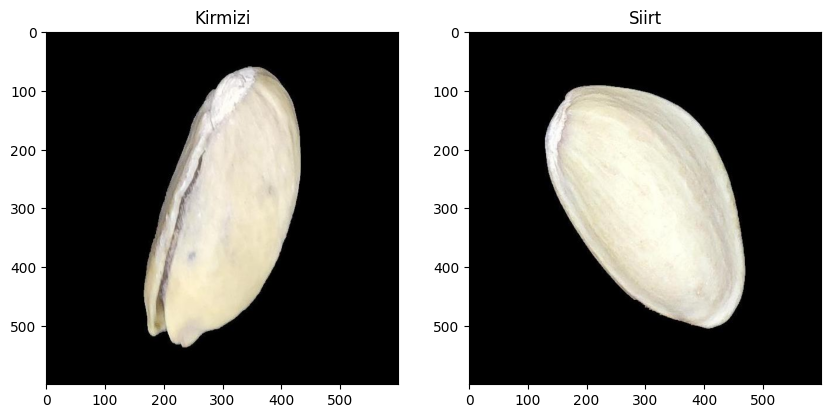

In [31]:
# what's the difference between Kirmizi and siirt
print(f"The Image size of Kirmizi: {imread(train_k[0]).shape}")
print(f"The Image size of Siirt: {imread(train_s[0]).shape}")
plt.figure(figsize=(8,4), dpi=200)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(imread(train_k[0]))
ax[0].set_title('Kirmizi')
ax[1].imshow(imread(train_s[0]))
ax[1].set_title('Siirt');

The image numbers of Kirmizi: 1232
The image numbers of Siirt: 916


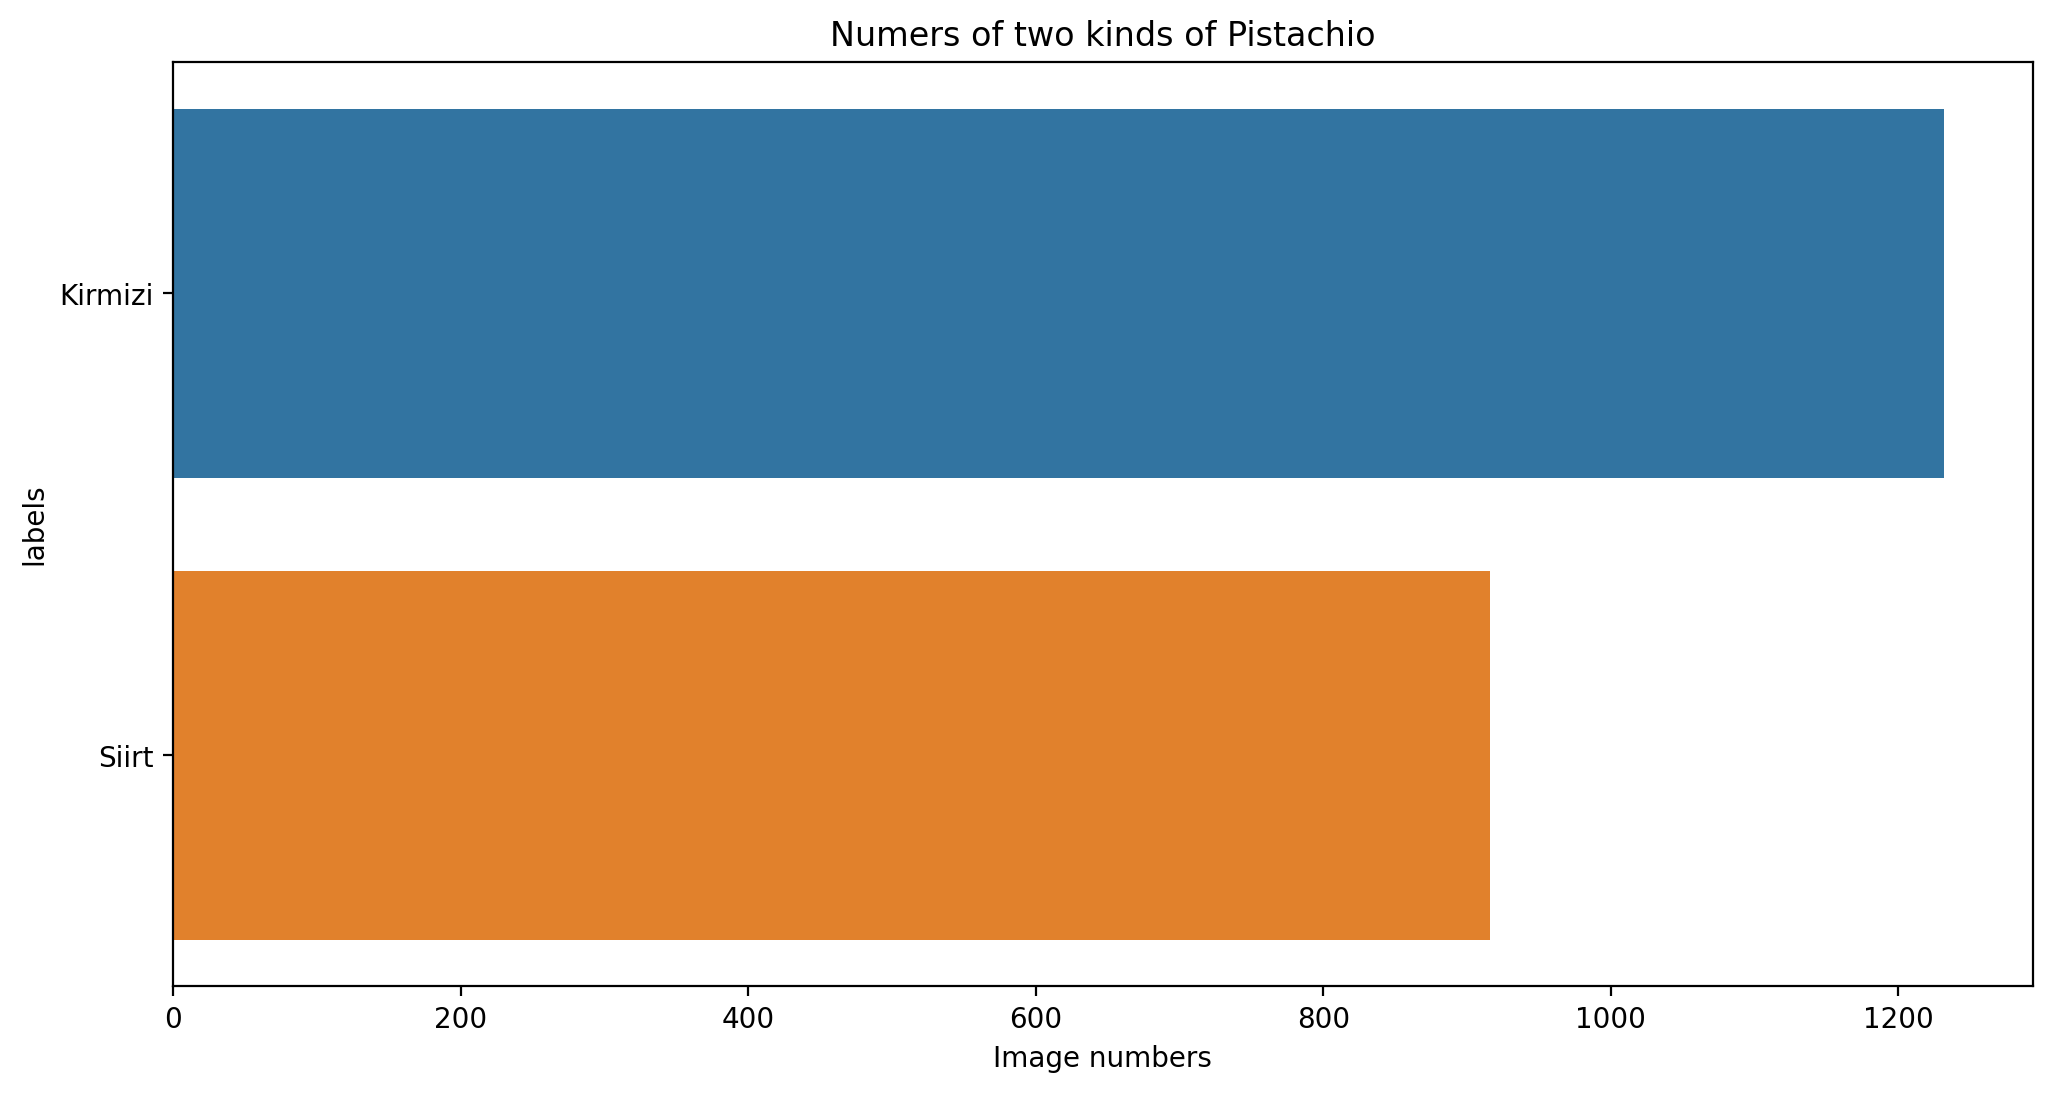

In [25]:
# the distribution of two kinds of Pistachio
num_k = len(os.listdir('/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio'))
num_s = len(os.listdir('/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio'))
df = pd.DataFrame({'labels':['Kirmizi', 'Siirt'],
                  'Image numbers':[num_k, num_s]})
print(f"The image numbers of Kirmizi: {num_k}")
print(f"The image numbers of Siirt: {num_s}")
plt.figure(figsize=(12,6), dpi=200)
sns.barplot(df, y='labels', x='Image numbers')
plt.title('Numers of two kinds of Pistachio');

 <!-- headings -->
 <a id="item4"></a>
## Part 4 : Image Generator  
**Next, I applied data augmentation to the images to enhance the learning process with different perspectives of the data. Additionally, I set the image shape to (224, 224, 3).**

In [9]:
# Initialize ImageDataGenerator
image_gen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.2, 
    rescale=1/255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_shape = (224, 224, 3)

**Alright, now we can apply random transformations to the entire dataset.**

In [10]:
# apply image generator to train and test dataset
batch_size = 64
train_gen = image_gen.flow_from_directory(
    train_path, target_size=image_shape[:2], color_mode='rgb',
    batch_size=batch_size, class_mode='binary'
)
test_gen = image_gen.flow_from_directory(
    test_path, target_size=image_shape[:2], color_mode='rgb',
    batch_size=batch_size, class_mode='binary'
)
print(train_gen.class_indices)
print(test_gen.class_indices)

Found 1717 images belonging to 2 classes.
Found 431 images belonging to 2 classes.
{'kirmizi': 0, 'siirt': 1}
{'kirmizi': 0, 'siirt': 1}


**Before we start building our model, let's randomly check if our images have indeed been successfully transformed. The images on the left are the original ones, while the images on the right have undergone the transformation.**

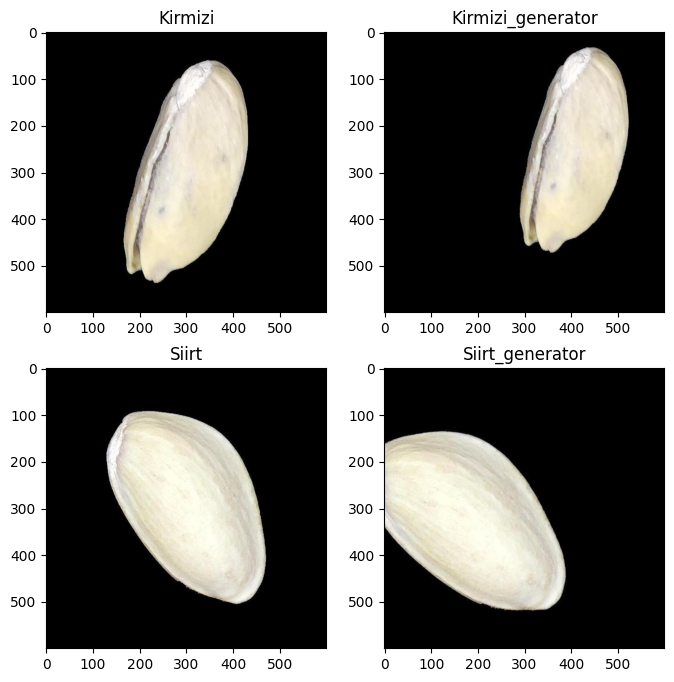

In [33]:
# how it looks like for image generator
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0,0].imshow(imread(train_k[0]))
ax[0,0].set_title('Kirmizi')
ax[1,0].imshow(imread(train_s[0]))
ax[1,0].set_title('Siirt')
ax[0,1].imshow(image_gen.random_transform(imread(train_k[0])))
ax[0,1].set_title('Kirmizi_generator')
ax[1,1].imshow(image_gen.random_transform(imread(train_s[0])))
ax[1,1].set_title('Siirt_generator');

 <!-- headings -->
 <a id="item5"></a>
 ## Part 5 : Create CNN Model
**First, we are going to build a CNN model to experiment with. Since we don't have much data, I'm keeping this model relatively simple to avoid overfitting.**

In [17]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=image_shape))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=early_stop)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 186624)            0         
                                                                 
 dense_6 (Dense)             (None, 256)              

<Axes: >

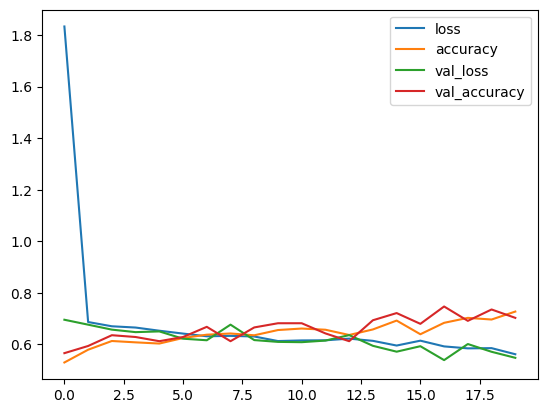

In [18]:
pd.DataFrame(model.history.history).plot()

**It seems that our self-built model is not performing very well, with an accuracy of only 0.68**

In [19]:
loss, accuracy = model.evaluate(test_gen)

7/7 [==============================] - 5s 752ms/step - loss: 0.5611 - accuracy: 0.6868


 <!-- headings -->
 <a id="item6"></a>
 ## Part 6 : Create VGG16 Model
 **One of the key characteristics of the VGG network is its uniform and consistent architecture. All convolutional layers use the same size (3x3) convolutional kernels and stride. VGG improves performance by increasing the depth of the network rather than using larger convolutional kernels or more complex structures.**

> During the fine-tuning process, I experimented with several approaches. Initially, **I used a neural network architecture with 256 and 128 layers and set the dropout rate to 0.4.** However, the performance as measured by val_accuracy, exhibited significant fluctuations. These pronounced variations indicated that the model wasn't generalizing well. To address this, **I simplified the neural network architecture by reducing the number of neurons and adjusted the dropout rate to 0.2. Additionally, I modified the default learning rate of the Adam optimizer.** Furthermore, I incorporated Batch Normalization to enhance the model's performance. **Ultimately, after fine-tuning, the model achieved an accuracy of 0.92.**

In [9]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_shape))
vgg16.trainable = False
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
# create layer
x = vgg16.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)
# create model
model = Model(inputs=vgg16.input, outputs=output)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=early_stop)


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

<Axes: >

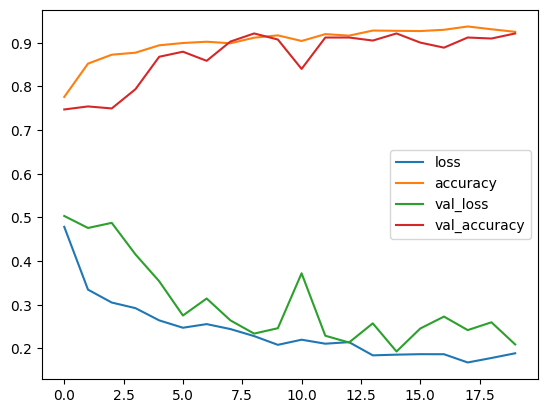

In [10]:
pd.DataFrame(model.history.history).plot()

In [11]:
loss, accuracy = model.evaluate(test_gen)

7/7 [==============================] - 5s 747ms/step - loss: 0.1997 - accuracy: 0.9211


 <!-- headings -->
 <a id="item7"></a>
 ## Part 7 : Create MobileNet Model
I believe that, for my dataset, VGG16 is still too complex and computationally intensive. Therefore, I opted for a more lightweight model like MobileNet. **In this model, I conducted some fine-tuning, including adjusting the learning rate, tuning the number of dense neurons, experimenting with l1_l2 regularization, and modifying the patience and epoch count for early stopping.** In the end, I achieved a very good model. The model exhibited a stable increase in val_accuracy without significant fluctuations. **Ultimately, it achieved an excellent accuracy of 0.98.**

In [13]:
mobile_net = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)
mobile_net.trainable = False
# create layer
x = mobile_net.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=mobile_net.input, outputs=output)
optimizer = Adam(learning_rate=0.00003)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
model_check = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[early_stop, model_check])

Epoch 1/20
27/27 [==============================] - 50s 2s/step - loss: 0.4014 - accuracy: 0.8288 - val_loss: 0.2639 - val_accuracy: 0.8886
Epoch 2/20
27/27 [==============================] - 45s 2s/step - loss: 0.2039 - accuracy: 0.9156 - val_loss: 0.2113 - val_accuracy: 0.9072
Epoch 3/20
27/27 [==============================] - 45s 2s/step - loss: 0.1407 - accuracy: 0.9447 - val_loss: 0.1803 - val_accuracy: 0.9281
Epoch 4/20
27/27 [==============================] - 45s 2s/step - loss: 0.1660 - accuracy: 0.9394 - val_loss: 0.1558 - val_accuracy: 0.9350
Epoch 5/20
27/27 [==============================] - 48s 2s/step - loss: 0.1248 - accuracy: 0.9569 - val_loss: 0.1433 - val_accuracy: 0.9582
Epoch 6/20
27/27 [==============================] - 46s 2s/step - loss: 0.1150 - accuracy: 0.9540 - val_loss: 0.1053 - val_accuracy: 0.9675
Epoch 7/20
27/27 [==============================] - 45s 2s/step - loss: 0.1102 - accuracy: 0.9610 - val_loss: 0.1438 - val_accuracy: 0.9466
Epoch 8/20
27/27 [==

<Axes: >

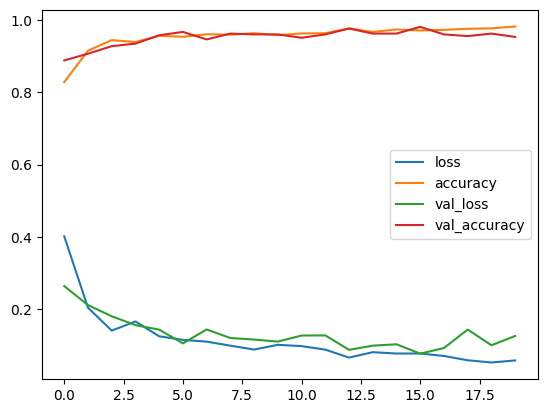

In [26]:
pd.DataFrame(model.history.history).plot()

In [27]:
loss, accuracy = model.evaluate(test_gen)

7/7 [==============================] - 8s 1s/step - loss: 0.1040 - accuracy: 0.9675


 <!-- headings -->
 <a id="item8"></a>
 ## Part 8 : Create EfficientNet Model  
**Next, I attempted to use the more complex EfficientNet model. However, regardless of how I adjusted the parameters, the model's val_accuracy remained at a guessing level, and it appeared that the model couldn't perform well.**

In [34]:
enetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=image_shape)
enetb0.trainable = False

# for layer in enetb0.layers[:-15]:
#     layer.trainable = False
x = enetb0.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=enetb0.input, outputs=output)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[early_stop])

Epoch 1/20


2023-09-07 08:17:47.779666: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 83s 3s/step - loss: 0.8783 - accuracy: 0.4927 - val_loss: 0.7061 - val_accuracy: 0.5731
Epoch 2/20
27/27 [==============================] - 26s 955ms/step - loss: 0.7600 - accuracy: 0.5183 - val_loss: 0.7743 - val_accuracy: 0.5731
Epoch 3/20
27/27 [==============================] - 26s 955ms/step - loss: 0.7530 - accuracy: 0.5323 - val_loss: 0.7473 - val_accuracy: 0.5731
Epoch 4/20
27/27 [==============================] - 26s 975ms/step - loss: 0.7396 - accuracy: 0.5288 - val_loss: 0.7432 - val_accuracy: 0.5731
Epoch 5/20
27/27 [==============================] - 27s 991ms/step - loss: 0.7518 - accuracy: 0.5312 - val_loss: 0.7163 - val_accuracy: 0.5731
Epoch 6/20
27/27 [==============================] - 26s 964ms/step - loss: 0.7162 - accuracy: 0.5626 - val_loss: 0.7730 - val_accuracy: 0.5731


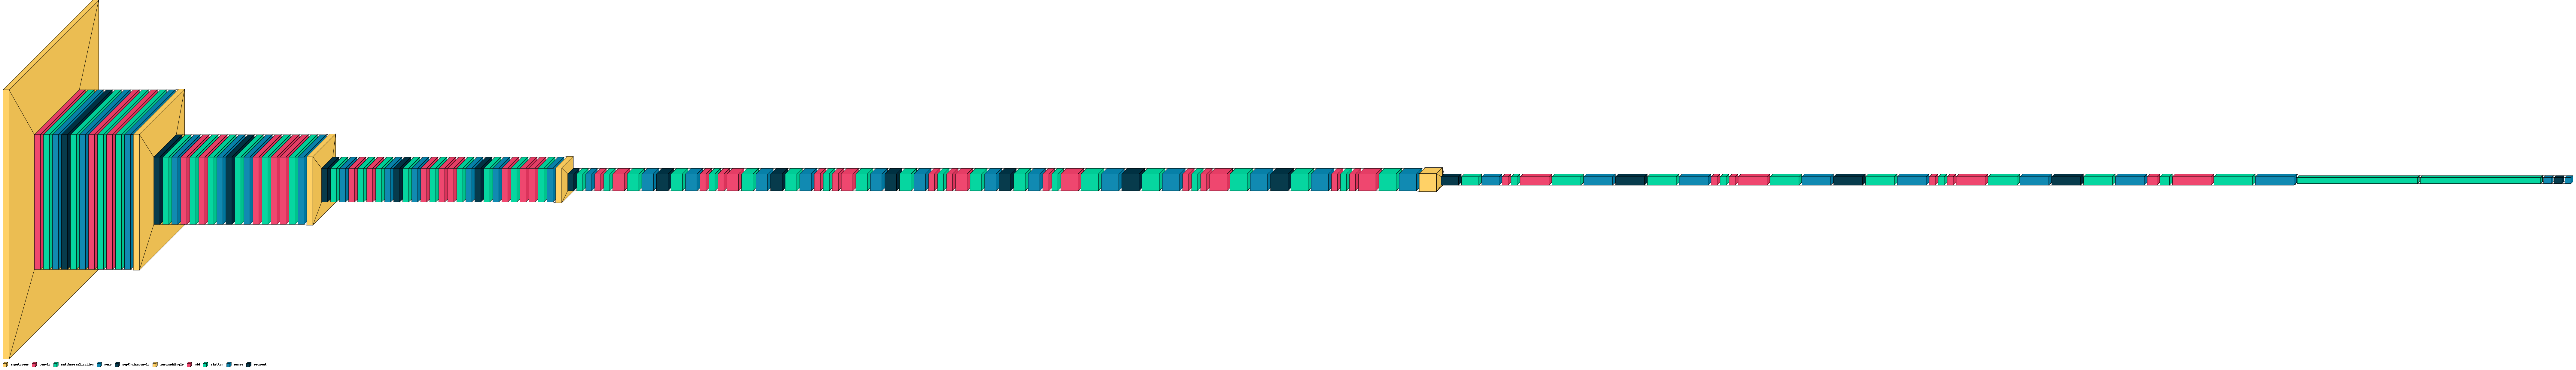

In [42]:
import visualkeras
visualkeras.layered_view(model, legend=True) 

 <!-- headings -->
 <a id="item9"></a>
 ## Part 9 : Predict and Evaluate Model with Data Visualization
 **In the end, we decided to use the best-performing model, MobileNet, for prediction. I randomly selected 16 images from the test set and labeled them with their original classes and predicted classes as titles. It's evident that almost all the predictions are quite accurate.**

In [43]:
# predict the model
y_pred = model.predict(test_gen)

7/7 [==============================] - 6s 676ms/step


1/1 [==============================] - 0s 23ms/step


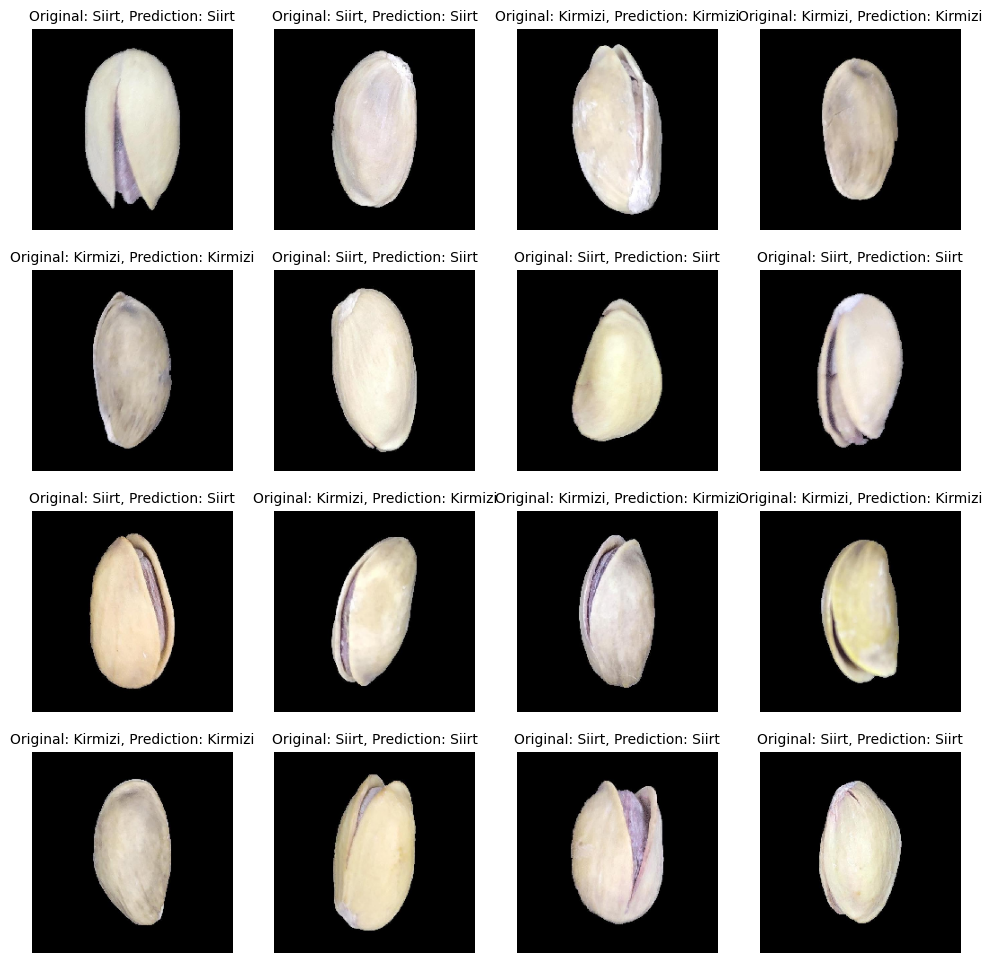

In [20]:
# combine the image of two folder
test_Kirmizi_folder = "/kaggle/working/test/kirmizi"
test_Siirt_folder = "/kaggle/working/test/siirt"
Kirmizi_files = [os.path.join(test_Kirmizi_folder, fname) for fname in os.listdir(test_Kirmizi_folder)]
Siirt_files = [os.path.join(test_Siirt_folder, fname) for fname in os.listdir(test_Siirt_folder)]
test_combine = Kirmizi_files + Siirt_files

# random pickup 16 images
random_indices = np.random.randint(0, len(test_combine), size=16)

# create plot 
fig, ax = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(ax.flat):
    random_n = random_indices[i]
    img_path = test_combine[random_n]
    
    # loading image and preprocessing
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, axis=0)
    
    # predict the image
    pred = model.predict(img)
    pred = (pred > 0.5).astype(int)[0][0]
    
    # create title of the image
    original_label = "Kirmizi" if "kirmizi" in img_path else "Siirt"
    pred_label = "Kirmizi" if pred == 0 else "Siirt"
    ax.imshow(img[0])
    ax.set_title(f"Original: {original_label}, Prediction: {pred_label}", fontsize=10)
    ax.axis("off")


## Thank you for reading, and if you found my approach helpful, please consider giving me a vote.